# Singal To Noise All Models
 - Calculates the singal to nosie for all models in longrunmip for GMST
 - Fraction of models stable for windows for GMST
 
 PHD-9:
 * read_and_merge_netcdfs moved from longrunmip_loader to open_ds


In [90]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from importlib import reload
import matplotlib as mpl
import string
import matplotlib.ticker as mticker
import os, sys
import constants
sys.path.append(constants.MODULE_DIR)
import sn_plotting as sn_plot
import xarray_class_accessors as xca
import open_ds
import signal_to_noise as sn
import xarray_extender as xce
import utils
from classes import ExperimentTypes
from itertools import groupby
warnings.filterwarnings('ignore')
logger = utils.get_notebook_logger()

from functools import partial

In [91]:
import dask.distributed
import tempfile
tempdir = tempfile.TemporaryDirectory('dask-worker-space')
dask.distributed.Client(local_directory=tempdir.name, memory_limit='32gb')

Using selector: EpollSelector


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:42967/status,
Dashboard: http://127.0.0.1:42967/status,Workers: 4
Total threads: 16,Total memory: 119.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33927,Workers: 4
Dashboard: http://127.0.0.1:42967/status,Total threads: 16
Started: Just now,Total memory: 119.21 GiB
Comm: tcp://127.0.0.1:41951,Total threads: 4
Dashboard: http://127.0.0.1:46763/status,Memory: 29.80 GiB
Nanny: tcp://127.0.0.1:35397,


In [455]:
VARIABLE_INFO = constants.VARIABLE_INFO
VARIABLE_INFO

{'tas': {'longname': 'Near-surface air temperature', 'units': '$^{\\circ}C$'},
 'pr': {'longname': 'Precipitation', 'units': 'mm\\year'},
 'netTOA': {'longname': 'Net TOA flux'},
 'sic': {'longname': 'Sea Ice Area Fraction', 'units': 'fraction'},
 'psl': {'longname': 'Sea level pressure'},
 'tos': {'longname': 'Sea surface temperature', 'units': '$^{\\circ}C$'},
 'surf': {'longname': 'Neat Ocean Heat Uptake'}}

In [456]:
experiment_params = constants.EXPERIMENTS_TO_RUN[6] #0, 1, 2, 3, 4, 5, 6, 7 complete
experiment_params

{'variable': 'sic', 'mask': 'sea', 'hemisphere': 'southern_hemisphere'}

In [457]:
notebook_number='03'
ROOT_DIR = os.path.join(constants.LONGRUNMIP_DIR, experiment_params["variable"], 'regrid_retimestamped')
ROOT_DIR

'/g/data/w40/ab2313/PhD/longrunmip/sic/regrid_retimestamped'

In [458]:
units = VARIABLE_INFO[experiment_params["variable"]]['units']
longname = VARIABLE_INFO[experiment_params["variable"]]['longname']

print(f'{longname=}', f'{units=}', sep=' , ')

longname='Sea Ice Area Fraction' , units='fraction'


# Loading Data

In [459]:
models_to_get = open_ds.get_models_longer_than_length()
utils.pprint_list(models_to_get, num_start_items=7)

lenght = 7
 0. ccsm3
 1. cesm104
 2. cnrmcm61
 3. hadcm3l
 4. ipslcm5a
 5. mpiesm11
 6. mpiesm12


In [460]:
files_to_open_experiment = open_ds.get_file_names_from_from_directory(ROOT_DIR,
                                                           ExperimentTypes.ABRUPT4X,
                                                           models_to_get)

files_to_open_control = open_ds.get_file_names_from_from_directory(ROOT_DIR,
                                                           ExperimentTypes.CONTROL,
                                                           models_to_get)
utils.pprint_list(files_to_open_experiment, num_start_items=5)

model='cesm104' - found_fname=None - No file found
lenght = 6
 0. sic_mon_CCSM3_abrupt4x_2120_g025.nc
 1. sic_mon_CNRMCM61_abrupt4x_1850_g025.nc
 2. sic_mon_HadCM3L_abrupt4x_1000_g025.nc
 3. sic_mon_IPSLCM5A_abrupt4x_1000_g025.nc
 4. sic_mon_MPIESM11_abrupt4x_4520_g025.nc


In [480]:
open_ds.read_longrunmip_netcdf('sic_mon_MPIESM11_abrupt4x_4520_g025.nc', ROOT_DIR)

<xarray.Dataset>
Dimensions:   (time: 1200, lat: 72, lon: 144)
Coordinates:
  * time      (time) object 0001-12-31 00:00:00 ... 1200-12-31 00:00:00
  * lon       (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat       (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
    depth     float64 0.0
Data variables:
    mpiesm11  (time, lat, lon) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0
Attributes:
    length:   4458

In [461]:
control_ds = open_ds.read_and_merge_netcdfs(files_to_open_control, ROOT_DIR, 
                                            mask=experiment_params['mask'])
abrupt4x_ds = open_ds.read_and_merge_netcdfs(files_to_open_experiment, ROOT_DIR,
                                             mask=experiment_params['mask'])
abrupt4x_ds

Removing first 10 steps for sic_mon_CCSM3_control_1530_g025.nc


<xarray.Dataset>
Dimensions:   (time: 1200, lat: 72, lon: 144)
Coordinates:
  * time      (time) object 0001-12-31 00:00:00 ... 1200-12-31 00:00:00
  * lon       (lon) float32 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat       (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
    depth     float64 0.0
Data variables:
    ccsm3     (time, lat, lon) float32 nan nan nan nan ... 0.3946 0.3841 0.384
    cnrmcm61  (time, lat, lon) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    hadcm3l   (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    ipslcm5a  (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    mpiesm11  (time, lat, lon) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    mpiesm12  (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    length:   2120

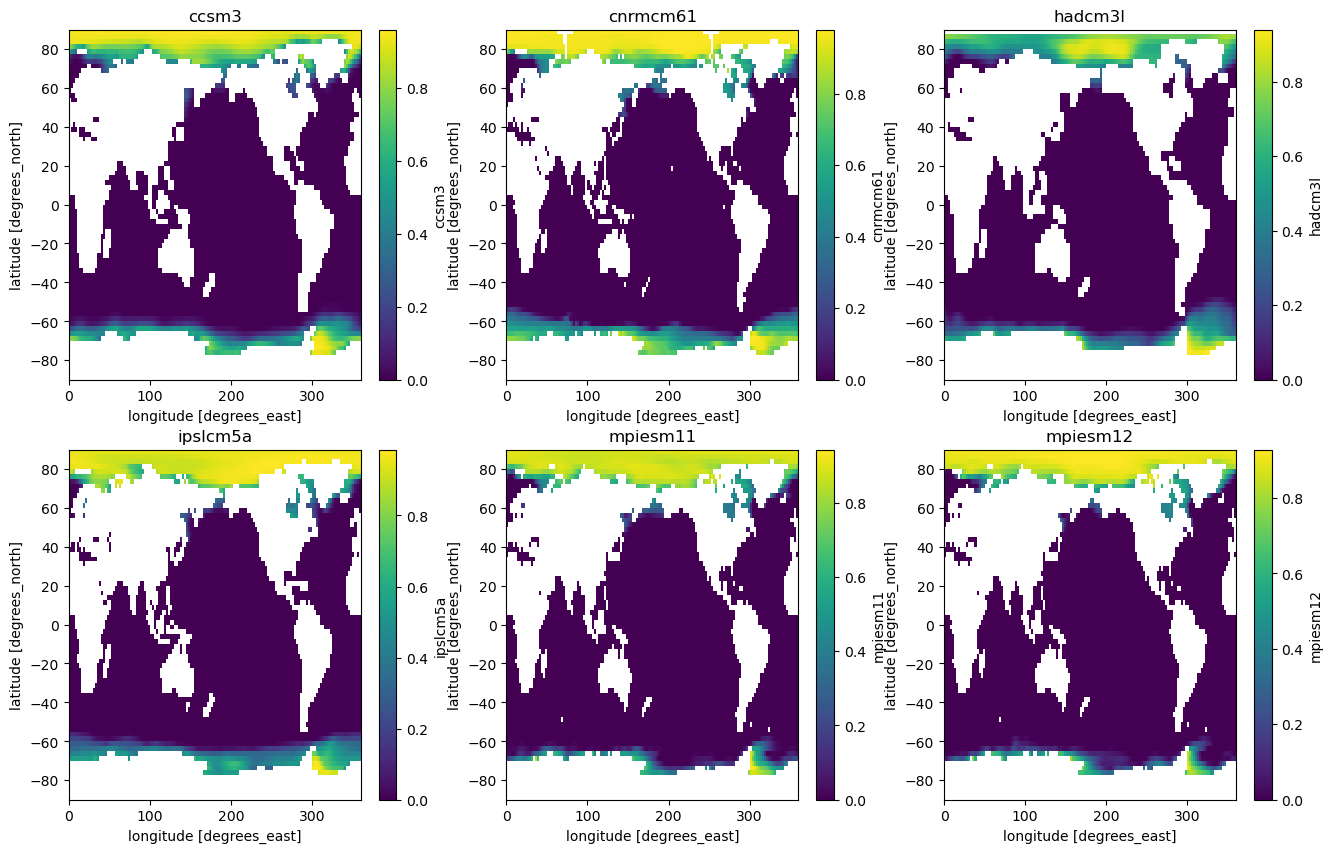

In [462]:
models = list(abrupt4x_ds.data_vars)
num_cols = 3
num_rows = int(np.ceil(len(models)/num_cols))

fig = plt.figure(figsize=(16,10))

for i,model in enumerate(models):
    ax = fig.add_subplot(num_rows, num_cols, i+1)
    
    abrupt4x_ds[model].isel(time=0).plot(ax=ax)
    ax.set_title(model)
    
    ax.set_title(model)

In [463]:
constants.HEMISPHERE_LAT[experiment_params['hemisphere']]

(-90, 0)

In [464]:
abrupt4x_mean,control_ds_mean = sn.calculate_global_value(abrupt4x_ds, control_ds, 
                                                          experiment_params["variable"],
                                                constants.HEMISPHERE_LAT[experiment_params['hemisphere']])

In [465]:
RUN_PARAMS = dict(end_window = 370)# 370 is standard
RUN_PARAMS['end_window']

370

In [466]:
max_effective_length = 600 # sn.get_upper_lim(abrupt4x_mean, RUN_PARAMS['end_window']) # Broken
max_effective_length

600

In [467]:
%%time
stable_sn_ds, unstable_sn_ds = abrupt4x_mean.sn_ds.sn_multiwindow(
    control_ds_mean, end_window=RUN_PARAMS['end_window'], step_window=2, parallel=True)


====ccsm3


Experiment
--------

20, 32, 26, 38, 44, 56, 50, 62, 68, 86, 80, 74, 92, 98, 104, 110, 58, 64, 76, 88, 22, 40, 46, 70, 52, 94, 34, 28, 100, 78, 24, 66, 82, 112, 106, 42, 36, 116, 48, 90, 84, 122, 96, 30, 54, 102, 60, 108, 72, 118, 128, 134, 140, 114, 124, 146, 152, 158, 164, 170, 142, 176, 182, 188, 120, 136, 154, 160, 126, 200, 194, 148, 144, 130, 190, 178, 162, 166, 202, 156, 138, 150, 172, 184, 196, 192, 180, 132, 204, 212, 206, 168, 218, 174, 224, 230, 248, 186, 236, 242, 198, 254, 260, 266, 208, 272, 220, 214, 278, 284, 238, 244, 250, 290, 226, 232, 262, 296, 216, 256, 268, 210, 274, 222, 292, 246, 264, 286, 252, 228, 280, 302, 240, 258, 298, 308, 294, 270, 314, 234, 320, 288, 326, 276, 332, 304, 338, 282, 344, 316, 350, 322, 300, 356, 362, 310, 368, 328, 306, 346, 340, 352, 334, 358, 364, 312, 348, 324, 354, 318, 342, 330, 366, 360, 336, 
Control
------

20, 26, 32, 38, 50, 56, 44, 62, 68, 74, 80, 92, 86, 98, 110, 104, 22, 58, 40, 28, 34, 52, 94, 64, 46, 76, 88, 82, 

20, 26, 32, 38, 44, 50, 56, 62, 74, 68, 80, 86, 92, 98, 104, 28, 110, 52, 34, 64, 76, 88, 22, 70, 58, 40, 46, 100, 30, 106, 94, 66, 112, 36, 82, 72, 78, 54, 24, 60, 90, 102, 48, 114, 116, 42, 84, 122, 108, 96, 128, 134, 118, 140, 152, 146, 124, 158, 164, 170, 176, 182, 188, 130, 136, 120, 194, 142, 148, 126, 154, 200, 206, 166, 160, 132, 172, 184, 212, 178, 144, 196, 190, 162, 218, 138, 224, 174, 168, 186, 202, 180, 150, 156, 230, 208, 192, 198, 220, 226, 236, 242, 204, 214, 248, 254, 260, 210, 266, 244, 228, 232, 272, 222, 278, 284, 216, 262, 238, 290, 302, 296, 288, 308, 250, 246, 256, 286, 274, 234, 268, 304, 264, 280, 292, 252, 240, 258, 276, 270, 298, 306, 282, 314, 294, 320, 326, 332, 338, 344, 300, 350, 356, 362, 316, 310, 322, 368, 328, 352, 318, 346, 340, 334, 312, 324, 358, 364, 330, 354, 342, 360, 366, 336, 348, 
====mpiesm12


Experiment
--------

20, 56, 26, 38, 32, 50, 44, 62, 68, 74, 80, 86, 92, 98, 104, 110, 58, 22, 76, 46, 34, 40, 82, 52, 28, 70, 100, 64, 112, 106, 54,

In [468]:
number_models_present = sn.count_over_data_vars(abrupt4x_mean, list(unstable_sn_ds.data_vars), dim='model')

unstable_number_da = sn.number_finite(unstable_sn_ds)
stable_number_da = sn.number_finite(stable_sn_ds)

unstable_number_da

<xarray.DataArray (window: 175, time: 1182)>
array([[0, 4, 4, ..., 0, 0, 0],
       [0, 5, 5, ..., 0, 0, 0],
       [0, 5, 5, ..., 0, 0, 0],
       ...,
       [0, 5, 5, ..., 0, 0, 0],
       [0, 5, 5, ..., 0, 0, 0],
       [0, 5, 5, ..., 0, 0, 0]])
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 1182-12-31 00:00:00
    depth    float64 0.0
  * window   (window) int64 20 22 24 26 28 30 32 ... 356 358 360 362 364 366 368

In [469]:
%%time
stable_point_ds = sn.get_stable_point_all_datavars(unstable_sn_ds)
stable_point_ds

CPU times: user 1.28 s, sys: 93.9 ms, total: 1.38 s
Wall time: 1.38 s


<xarray.Dataset>
Dimensions:  (window: 175, model: 6)
Coordinates:
    depth    float64 0.0
  * window   (window) int64 20 22 24 26 28 30 32 ... 356 358 360 362 364 366 368
  * model    (model) <U8 'ccsm3' 'cnrmcm61' 'hadcm3l' ... 'mpiesm11' 'mpiesm12'
Data variables:
    time     (model, window) int64 -1 -1 -1 -1 30 53 ... 438 438 437 437 443 443

# Plots

### Mean Temp Plots

In [470]:
hemisphere_title = string.capwords(experiment_params['hemisphere'].replace('_', ' '))
hemisphere_title

'Southern Hemisphere'

In [471]:
mask_title = f'({experiment_params["mask"]} only)' if experiment_params["mask"] else ''
mask_title

'(sea only)'

In [472]:
run_tag = f'{notebook_number}_{experiment_params["variable"]}' +\
        f'_{experiment_params["hemisphere"]}_mask_{experiment_params["mask"]}'
run_tag

'03_sic_southern_hemisphere_mask_sea'

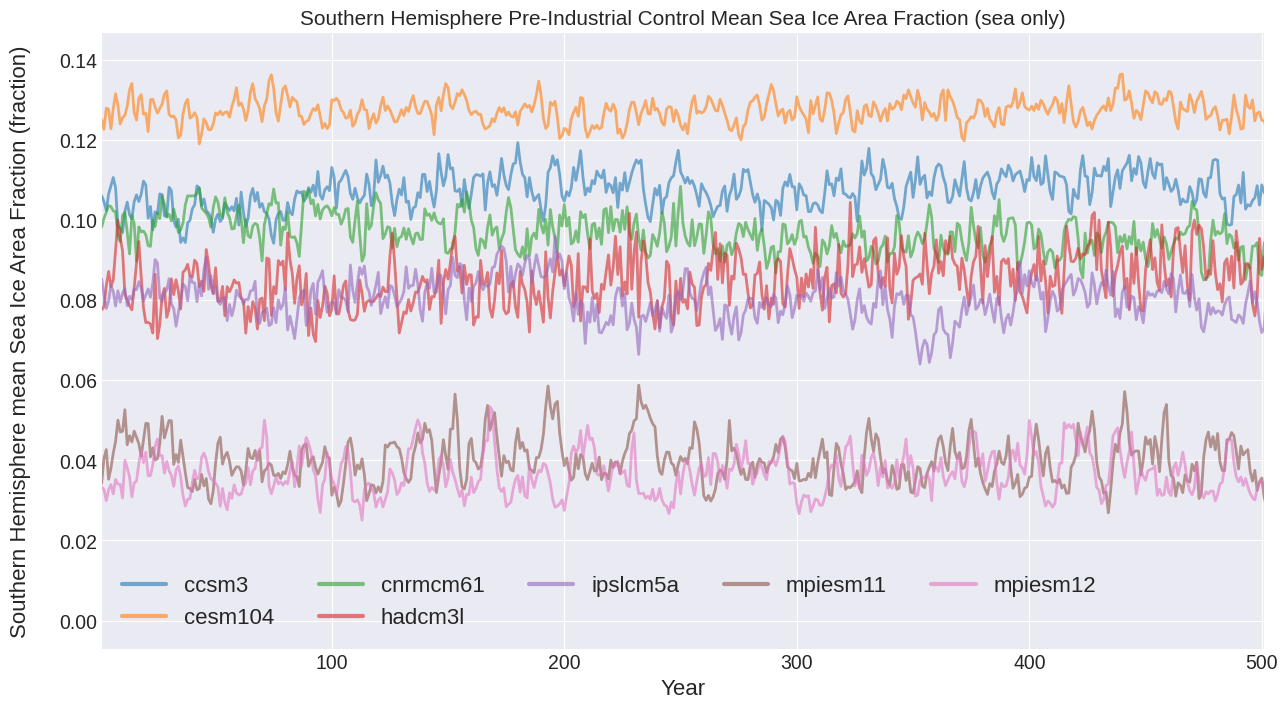

In [473]:
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(15,8))

time = control_ds_mean['time'].values
years = [t.year for t in time]
for var in list(control_ds_mean.data_vars):

    plot_kwargs = dict(alpha = 0.6,linewidth = 2)
        
    ax.plot(years, control_ds_mean[var].values, label=var, **plot_kwargs) #  - 273.15
    
ax.set_ylabel(f'{hemisphere_title} mean {longname} ({units})', size=16, labelpad=20)
ax.set_xlabel('Year', size=16)
ax.set_xlim(years[0], years[500])
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
leg = ax.legend(ncol = 5, fontsize=16)
[line.set_linewidth(3) for line in leg.get_lines()];
ax.set_title(f'{hemisphere_title} Pre-Industrial Control Mean {longname} {mask_title}', fontsize=15);

fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL, f'{run_tag}_mean_control.png'))

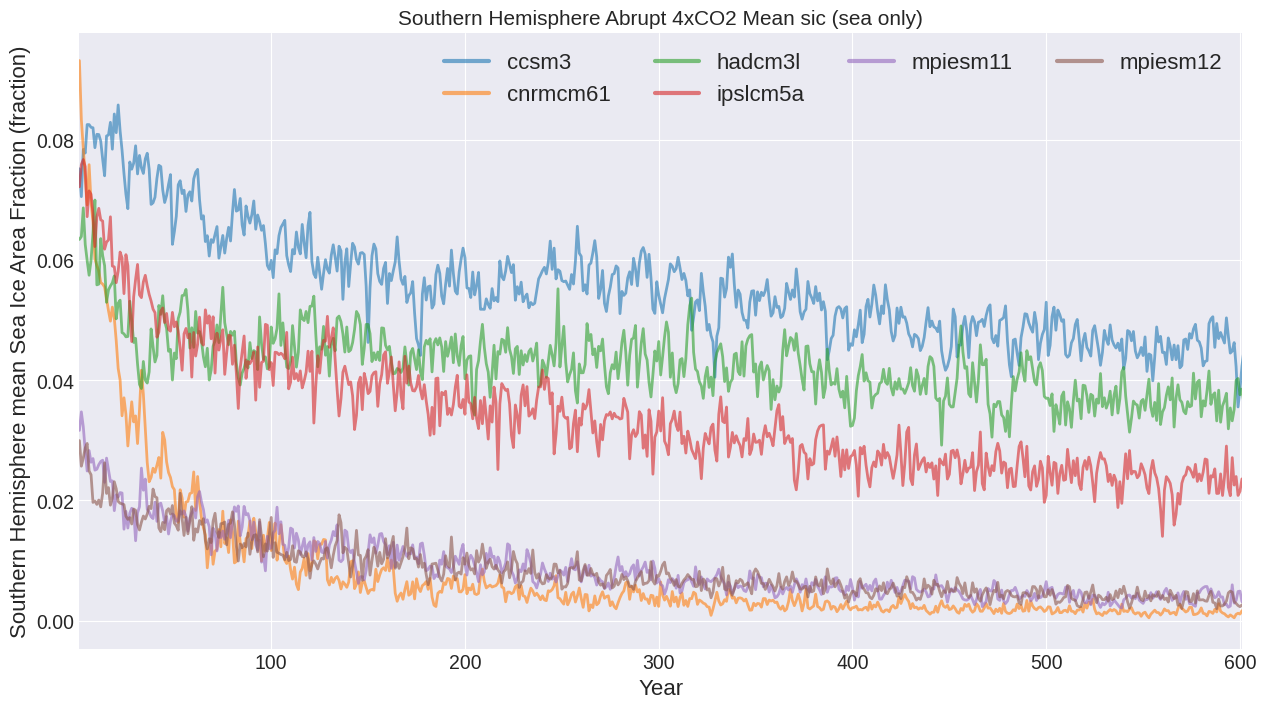

In [474]:
plt.style.use('seaborn-darkgrid')

data = abrupt4x_mean.where(abrupt4x_mean.time.dt.year < 13500, drop = True)

fig, ax = plt.subplots(figsize=(15,8))

for var in list(data.data_vars):
    
    # Removing nans from data
    da = data[var].dropna(dim='time')
    time = da.time.values
    years = [t.year for t in time]

    values = da.values
    
    line_kwargs = dict(alpha = 0.6,linewidth = 2)
    
    ax.plot(years, values, label=var, **line_kwargs)
    c = plt.gca().lines[-1].get_color()
#     ax.annotate(var, xy = (time[-1], values[-1]), color=c, zorder=1000, size=12)

ax.set_ylabel(f'{hemisphere_title} mean {longname} ({units})', size=16)
ax.set_xlabel('Year', size=16);
ax.set_title(f'{hemisphere_title} Abrupt 4xCO2 Mean {experiment_params["variable"]} {mask_title}', fontsize=15);

# ax.set_ylim([0,15]);|
ax.set_xlim(years[0], years[max_effective_length])
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
leg = ax.legend(ncol=4, fontsize = 16);
[line.set_linewidth(3) for line in leg.get_lines()];
fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL, f'{run_tag}_mean_abrupt4x.png'))

### Signal to Noise

In [475]:
models = [model for model in list(constants.MODEL_PARAMS) if model in stable_point_ds.model.values]
models

['ccsm3', 'mpiesm12', 'hadcm3l', 'mpiesm11', 'ipslcm5a', 'cnrmcm61']

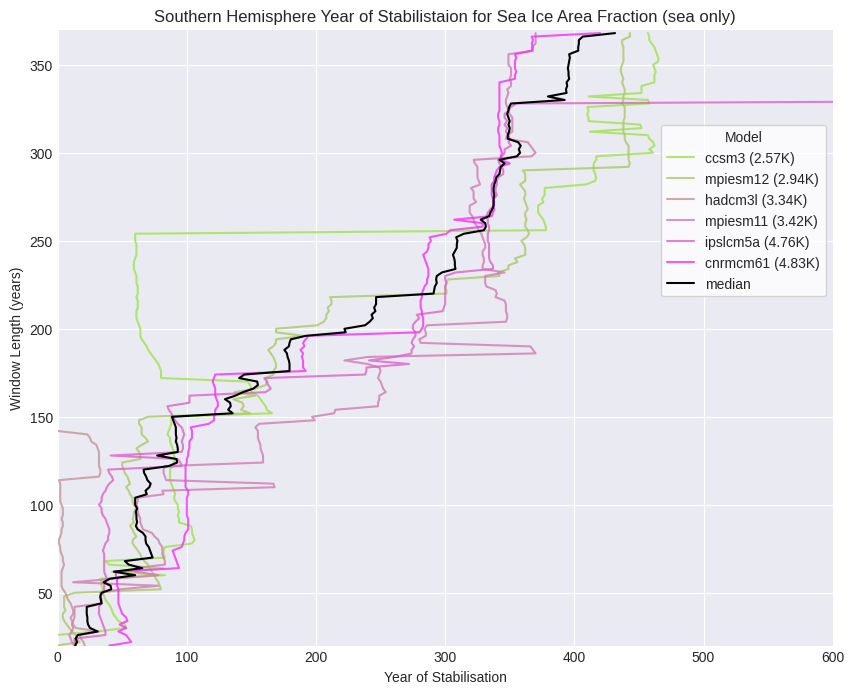

In [476]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(10, 8))

ax = fig.add_subplot(111)

for model in models:
    color = constants.MODEL_PARAMS[model]['color']
    ECS = constants.MODEL_PARAMS[model]['ECS']
    label = f'{model} ({ECS}K)' 
    da = stable_point_ds.sel(model=model).time.plot(ax=ax,y='window', label=label, color=color, linewidth=1.5,
                                                   alpha=0.8)
    
stable_point_ds.median(dim='model').time.plot(ax=ax,y='window', label='median', color='k', linewidth=1.5) 

ax.set_xlim(0, max_effective_length)
ax.set_ylim(20, RUN_PARAMS['end_window'])
leg = ax.legend(ncol=1, bbox_to_anchor=[1, 0.857], frameon=True, facecolor='white')
leg.set_title('Model')
leg.get_title().set_fontsize('10')
title = f'{hemisphere_title} Year of Stabilistaion for {longname} {mask_title}'
ax.set_title(title)
ax.set_xlabel('Year of Stabilisation')
ax.set_ylabel('Window Length (years)')


save_name = os.path.join(
    constants.IMAGE_SAVE_DIR_TOP_LEVEL, f'{run_tag}_all_models_stable_year.png')

fig.savefig(save_name, bbox_inches='tight', dpi=200)

ccsm3
No matching models found data_vars=['variable']
Saving /home/563/ab2313/gdata/images/PhD/top_level/03_sic_southern_hemisphere_mask_sea_ccsm3_signal_to_noise_multiwindow.png
mpiesm12
No matching models found data_vars=['variable']
Saving /home/563/ab2313/gdata/images/PhD/top_level/03_sic_southern_hemisphere_mask_sea_mpiesm12_signal_to_noise_multiwindow.png
hadcm3l
No matching models found data_vars=['variable']
Saving /home/563/ab2313/gdata/images/PhD/top_level/03_sic_southern_hemisphere_mask_sea_hadcm3l_signal_to_noise_multiwindow.png
mpiesm11
No matching models found data_vars=['variable']
Saving /home/563/ab2313/gdata/images/PhD/top_level/03_sic_southern_hemisphere_mask_sea_mpiesm11_signal_to_noise_multiwindow.png
ipslcm5a
No matching models found data_vars=['variable']
Saving /home/563/ab2313/gdata/images/PhD/top_level/03_sic_southern_hemisphere_mask_sea_ipslcm5a_signal_to_noise_multiwindow.png
cnrmcm61
No matching models found data_vars=['variable']
Saving /home/563/ab2313/gd

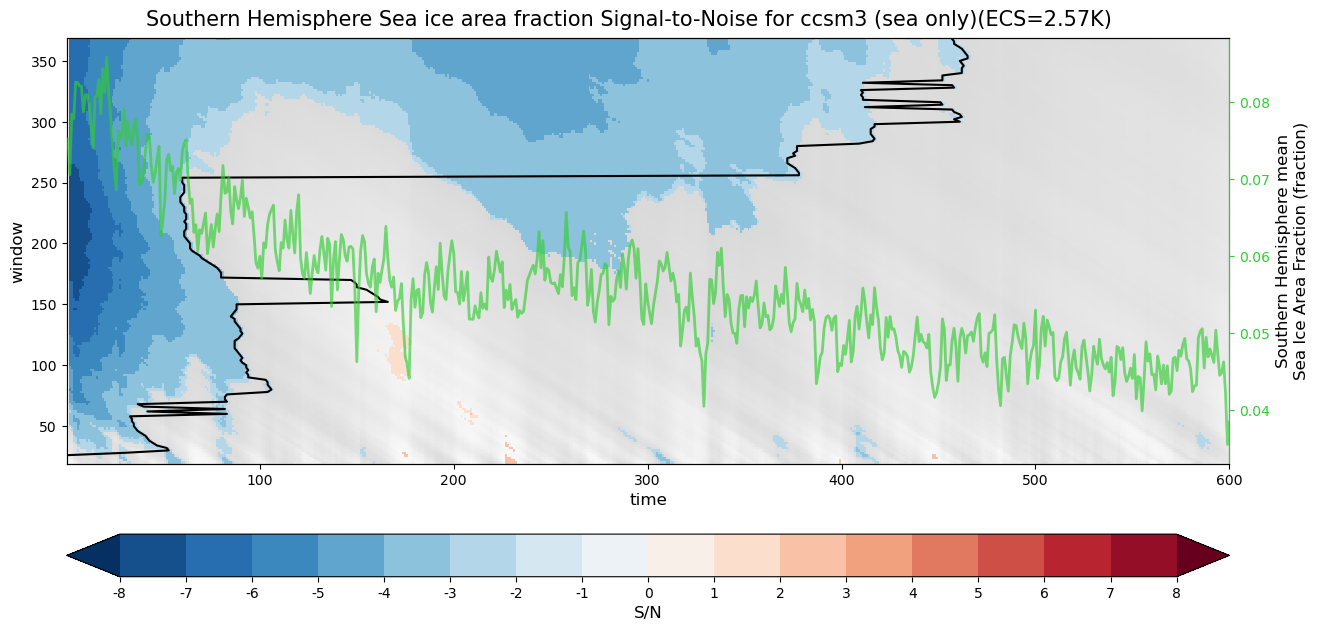

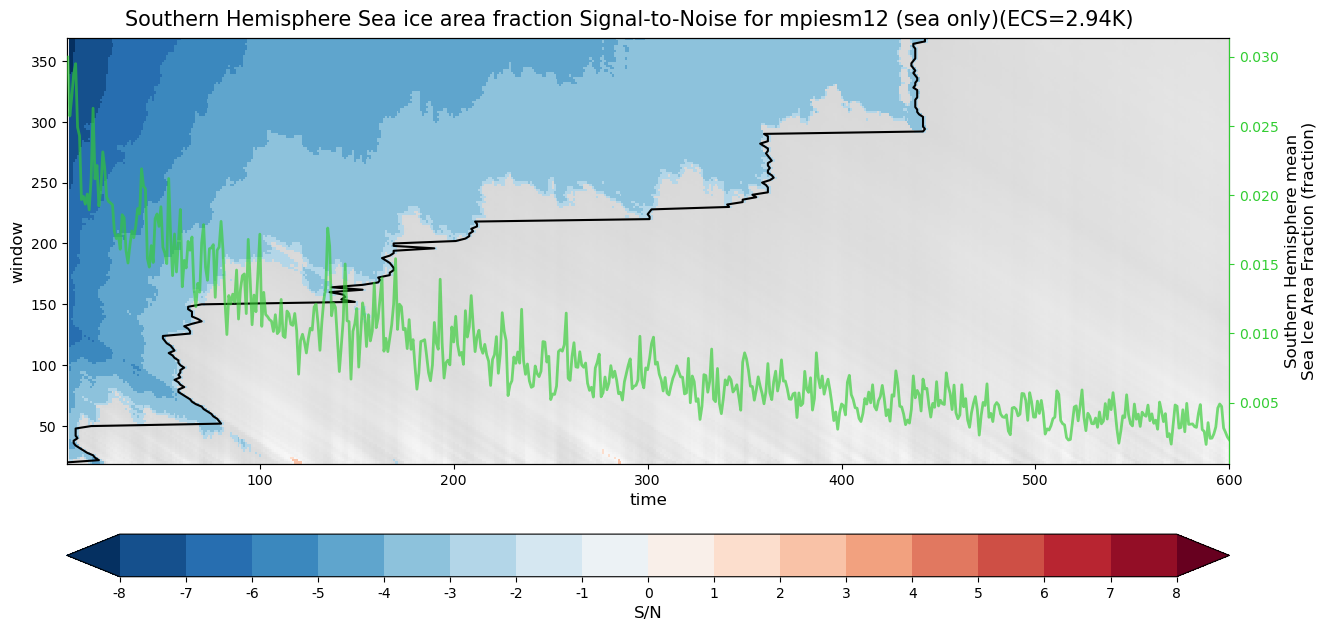

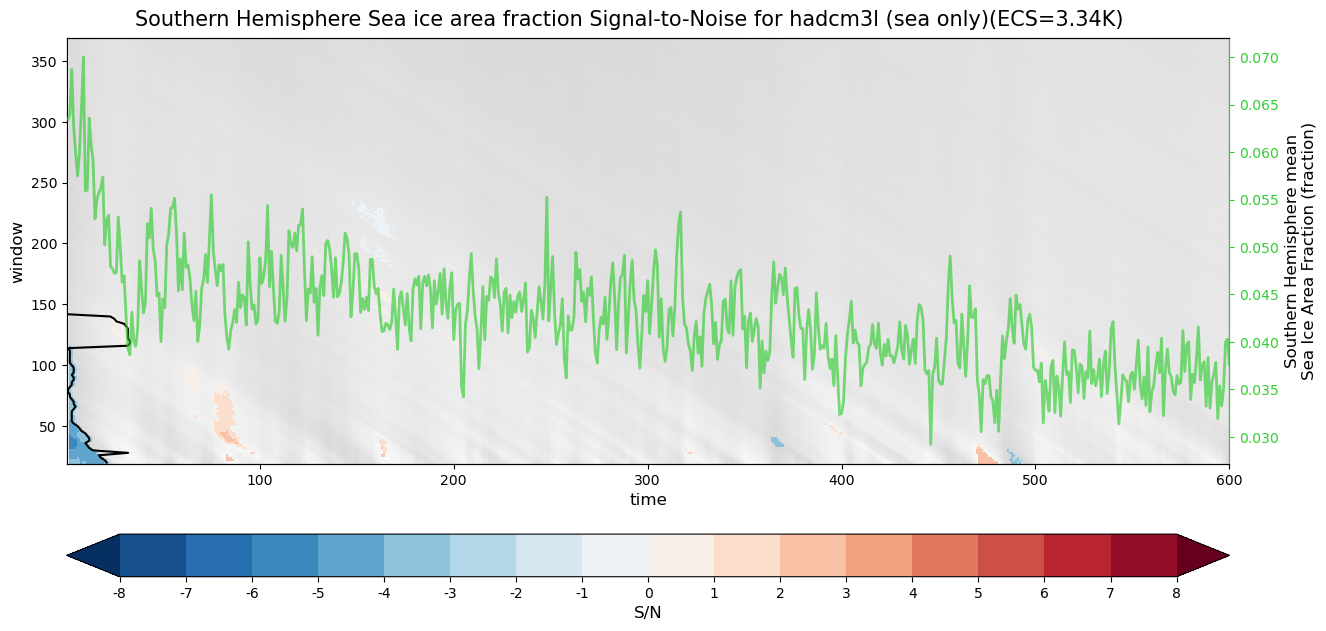

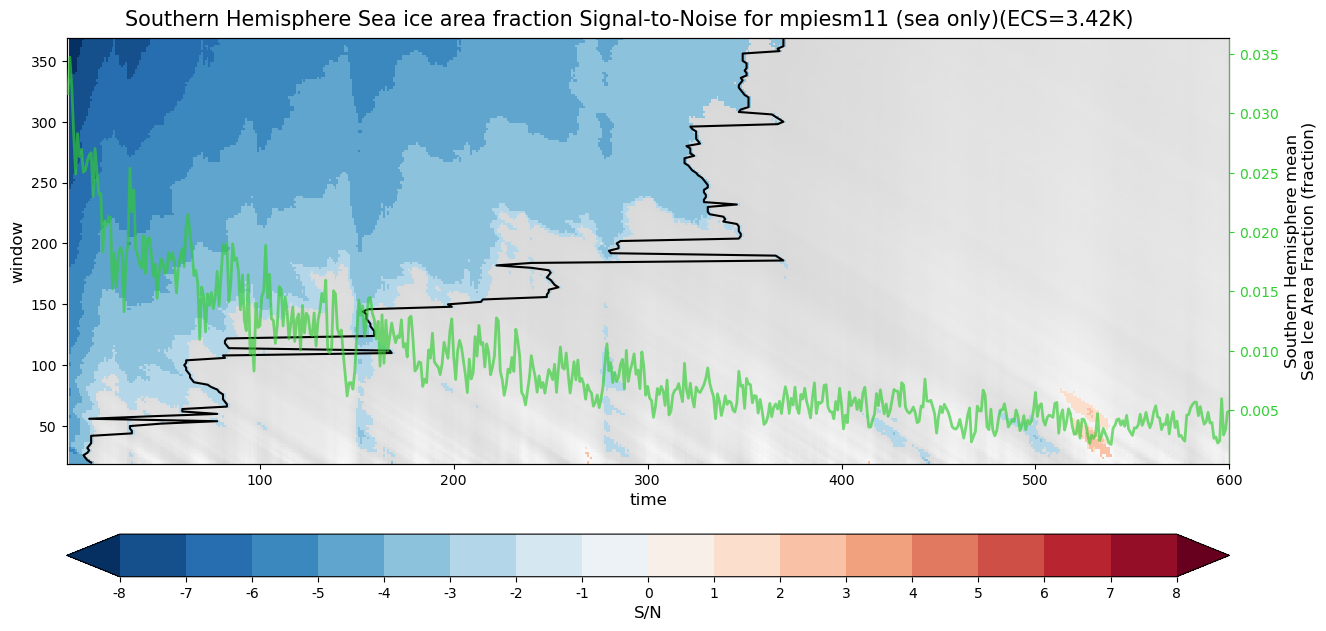

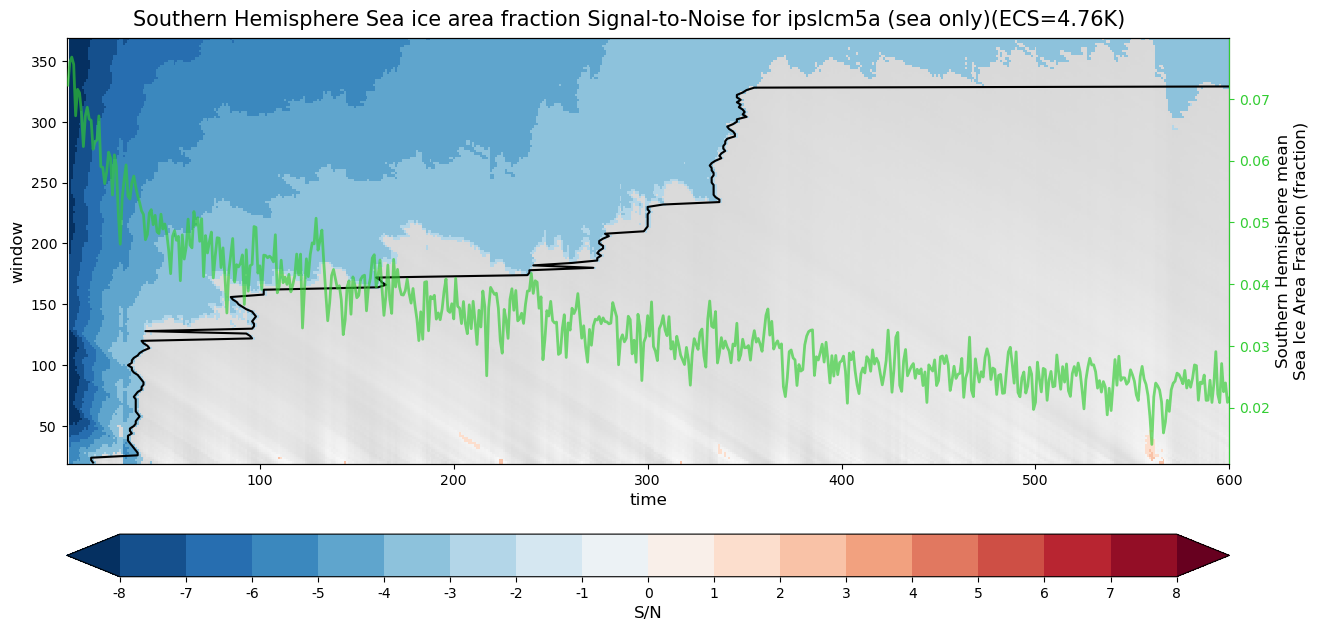

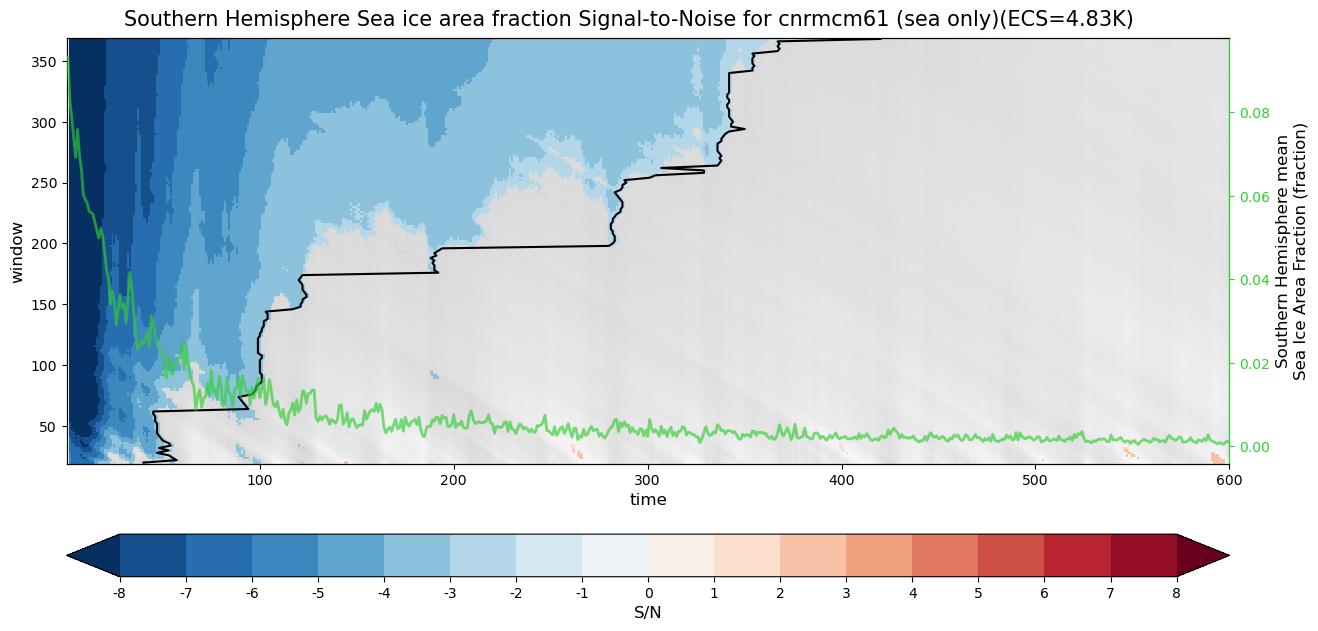

In [477]:
xupperlim = max_effective_length
reload(sn_plot)
mpl.rcParams.update(mpl.rcParamsDefault)

for model in list(models):
    print(model)
    ECS = constants.MODEL_PARAMS[model.lower()]['ECS']
    title = f'{hemisphere_title} {longname.capitalize()} Signal-to-Noise for {model} {mask_title}(ECS={ECS}K)'
    (fig, ax1, ax2, ax3, cbar) = sn_plot.sn_multi_window_in_time(unstable_sn_ds[model], 
                            stable_sn_ds[model], abrupt4x_mean[model].dropna(dim='time'),
                            title=title, step=1, xupperlim=xupperlim,
                            ax2_ylabel = f'{hemisphere_title} mean\n{longname} ({units})',
                                                                logginglevel='ERROR');

    stable_point_ds.sel(model=model).time.plot(y='window',  ax=ax1, color='k')
    ax1.set_title('')
    
    save_name = os.path.join(
        constants.IMAGE_SAVE_DIR_TOP_LEVEL, 
        f'{run_tag}_{model}_signal_to_noise_multiwindow.png')
    
    print(f'Saving {save_name}')
    fig.savefig(save_name, dpi=400, bbox_inches='tight')

In [478]:
cmap = "Blues" if experiment_params["variable"] == 'sic' else 'Reds'
cmap

'Blues'

{'ax2_ylabel': 'Global Mean\nSea Ice Area Fraction (fraction)',
 'cbar_label': 'Number of Unstable Models',
 'cbar_ncols': 3,
 'cbar_ticks': array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 'cbar_xticklabels': array([0, 1, 2, 3, 4, 5, 6]),
 'cbartick_offset': 0.5,
 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x7fcf522a4610>,
 'extend': 'neither',
 'filter_max': True,
 'height': 15,
 'hieght': 15,
 'hspace': 0.3,
 'label_size': 12,
 'levels': array([0, 1, 2, 3, 4, 5, 6, 7]),
 'line_alpha': 0.65,
 'line_color': 'limegreen',
 'step': 1,
 'title': 'Southern Hemisphere Fraction of Models Stable for Sea Ice Area '
          'Fraction (sea only)',
 'vmax': 7,
 'vmin': 0,
 'width': 12,
 'xlowerlim': None,
 'xupperlim': 500}
locator: <matplotlib.ticker.FixedLocator object at 0x7fcf521901c0>
cbar x-tick labels = [0 1 2 3 4 5 6]
data_vars=['ccsm3', 'cnrmcm61', 'hadcm3l', 'ipslcm5a', 'mpiesm11', 'mpiesm12']
0 ccsm3, 
1 mpiesm12, 
2 hadcm3l, 
3 mpiesm11, 
4 ipslcm5a, 
5 cnrmcm61, 
/hom

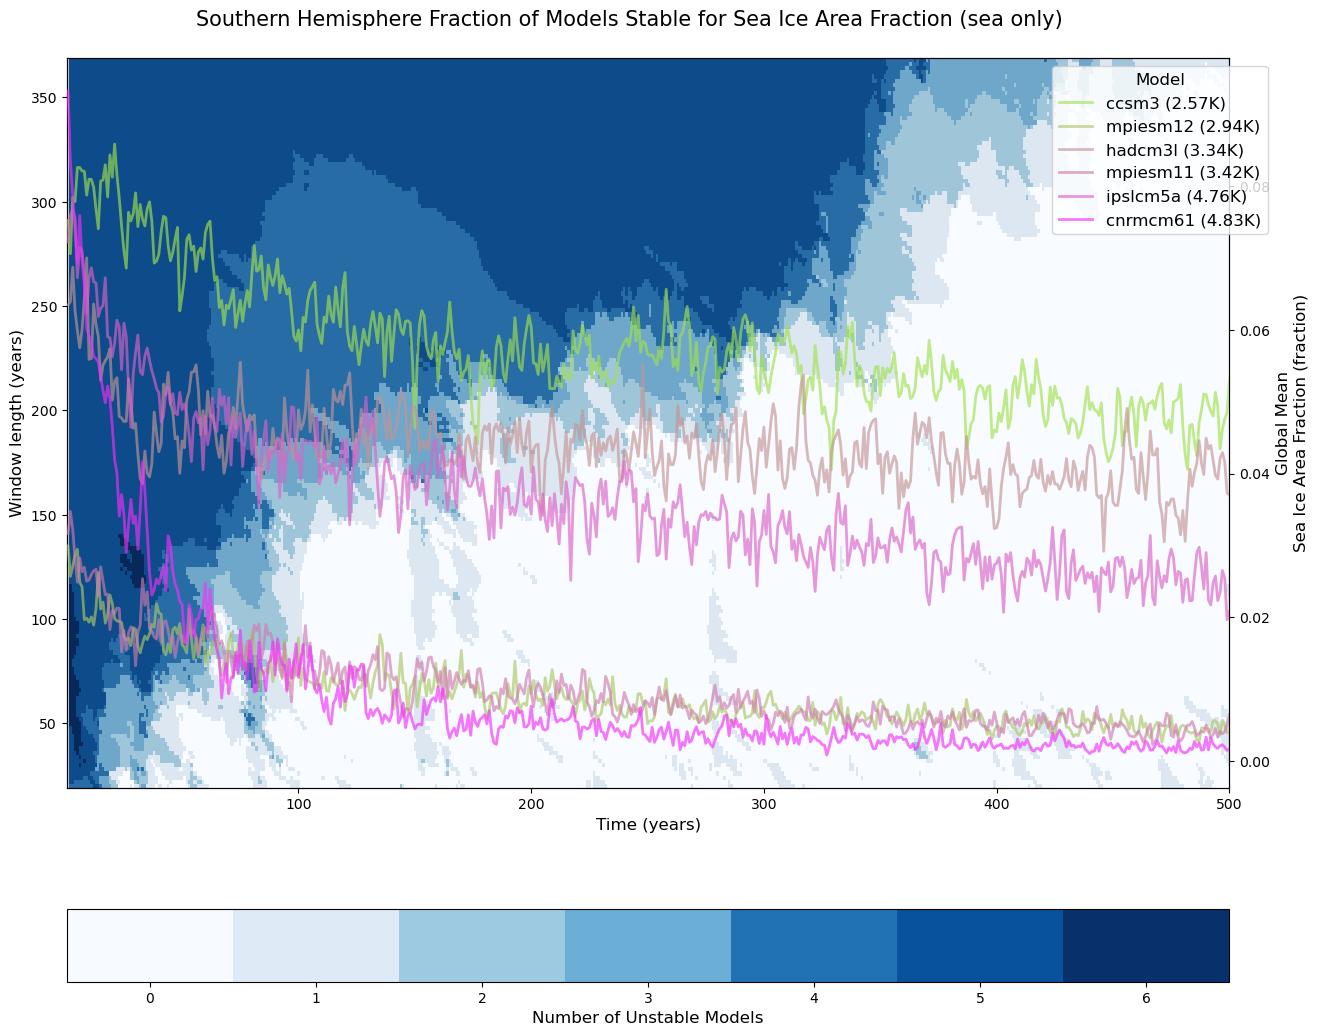

In [479]:
reload(sn_plot)
mpl.rcParams.update(mpl.rcParamsDefault)
fig, ax1, ax2, ax3,cbar = sn_plot.sn_multi_window_in_time(
    unstable_number_da, stable_number_da, abrupt4x_mean, 
    logginglevel='DEBUG', 
    hieght = 15, width = 12,
    vmin=0, vmax=len(models)+1, step=1, cbartick_offset = 0.5,
    cmap=cmap,
    extend='neither', xupperlim = 500,
    cbar_label= 'Number of Unstable Models', 
    ax2_ylabel = f'Global Mean\n{longname} ({units})',
    title = f'{hemisphere_title} Fraction of Models Stable for {longname} {mask_title}',
    cbar_ncols = 3, filter_max=True)


save_name = os.path.join(
        constants.IMAGE_SAVE_DIR_TOP_LEVEL, 
        f'{run_tag}_all_models_signal_to_noise_multiwindow.png')
print(save_name)
fig.savefig(save_name , dpi=200, bbox_inches='tight')